# JWST archive search for dwarf galaxy IFU data 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.table as table
import astropy.io as io
from astroquery.mast import Observations as obv 

How many JWST observations in the database?

In [2]:
print(obv.query_criteria_count(obs_collection="JWST"))

206061


Here is a list of dwarf spheroidals with D-factors from Bonnivard et al 2015 (https://academic.oup.com/mnras/article/453/1/849/1749464#78668950). Take this a prelminary target list.  Note that the MAST search is not case-sensitive and I have inserted wildcards to catch as many name variations as I can. 

In [3]:
targets_B2015 = ["*segue*", 
                 "*ursa*major*", 
                 "*willman*", 
                 "*coma*", 
                 "*ursa*minor*", 
                 "*bootes*", 
                 "*sculptor*", 
                 "*draco*", 
                 "*sextans*", 
                 "*carina*", 
                 "*hercules*", 
                 "*fornax*", 
                 "*leo*", 
                 "*canis*venatici*"]

get all targets thus far

In [4]:
matches = table.vstack([obv.query_criteria(obs_collection="JWST",  
                                             instrument_name="NIRSPEC/IFU",
                                              target_name=target)
                           for target in targets_B2015])


In [5]:
print(len(matches))
matches["target_name"]

21


KLEOPATRA
KLEOPATRA
KLEOPATRA
KLEOPATRA
KLEOPATRA
...
LEOI
LEOI
LEOI
LEOI


In [6]:
matches

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str7,str11,str4,str12,str8,str9,str1,str38,float64,float64,str8,str19,int64,float64,float64,float64,float64,float64,str100,float64,str4,str3,int64,str157,str64,str65,str6,bool,float64,str9,str9
science,JWST,CALJWST,NIRSPEC/IFU,JWST,F290LP;G395M,INFRARED,KLEOPATRA,--,jw01444-o001_t001_nirspec_g395m-f290lp,343.7770251042259,9.117393053537997,cube,"Stansberry, John A.",3,59747.92285902639,59747.93586094907,350.132,2870.0,5100.0,FGS-021 NIRSpec Moving Target Test,59774.8541666,1444,COM,--,POLYGON 343.775153118 9.115758143 343.775153118 9.117147032 343.776447245 9.117147032 343.776447245 9.115758143,mast:JWST/product/jw01444-o001_t001_nirspec_g395m-f290lp_s3d.jpg,mast:JWST/product/jw01444-o001_t001_nirspec_g395m-f290lp_s3d.fits,PUBLIC,True,nan,87464266,257078672
science,JWST,CALJWST,NIRSPEC/IFU,JWST,F290LP;G395M,INFRARED,KLEOPATRA,--,jw01444001001_03101_00002_nrs2,343.7754086302577,9.116159282221547,image,"Stansberry, John A.",2,59747.92674271852,59747.92809354167,87.533,2870.0,5100.0,FGS-021 NIRSpec Moving Target Test,59774.8541666,1444,COM,--,POLYGON 343.776008084 9.116344831 343.775649293 9.115529527 343.774846059 9.115862836 343.775204612 9.116678091,mast:JWST/product/jw01444001001_03101_00002_nrs2_rateints.jpg,mast:JWST/product/jw01444001001_03101_00002_nrs2_rateints.fits,PUBLIC,True,nan,87464234,257078742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
science,JWST,APT,NIRSPEC/IFU,JWST,F170LP;G235H,INFRARED,LEOI,--,jw03805001001_xx10f_00002_nirspec,152.10754583333335,12.310686111111112,spectrum,"Pacucci, Fabio",-1,nan,nan,1458.889,1660.0,5000.0,A NIRSpec Look at the Emission and Gas Kinematics of the SMBH in the Milky Way Dwarf Satellite Leo I,nan,3805,--,15,POLYGON 152.10745017071773 12.310056996168221 152.1068529797719 12.310727665257325 152.10751029501532 12.31130008733779 152.10810754240958 12.310629649235784,--,--,PUBLIC,False,nan,150112836,270889391
science,JWST,APT,NIRSPEC/IFU,JWST,F170LP;G235H,INFRARED,LEOI,--,jw03805001001_xx10g_00003_nirspec,152.10754583333335,12.310686111111112,spectrum,"Pacucci, Fabio",-1,nan,nan,1458.889,1660.0,5000.0,A NIRSpec Look at the Emission and Gas Kinematics of the SMBH in the Milky Way Dwarf Satellite Leo I,nan,3805,--,16,POLYGON 152.1075429350956 12.310018471109998 152.10694574447436 12.310689140400514 152.1076030598236 12.31126156225929 152.10820030689334 12.310591123955852,--,--,PUBLIC,False,nan,150112837,270889392
science,JWST,APT,NIRSPEC/IFU,JWST,F170LP;G235H,INFRARED,LEOI,--,jw03805001001_xx10h_00004_nirspec,152.10754583333335,12.310686111111112,spectrum,"Pacucci, Fabio",-1,nan,nan,1458.889,1660.0,5000.0,A NIRSpec Look at the Emission and Gas Kinematics of the SMBH in the Milky Way Dwarf Satellite Leo I,nan,3805,--,17,POLYGON 152.1074840750413 12.31010643893585 152.10688688406958 12.31077710809857 152.10754419951073 12.311349530098008 152.1081414469309 12.31067909192238,--,--,PUBLIC,False,nan,150112840,270889395


I think Kleopatra is an asteroid (https://en.wikipedia.org/wiki/216_Kleopatra).  The Leo I data is promising. 

In [7]:
obv.get_product_list(matches[matches["target_name"] == "LEOI"])

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,int64,str1,str1,int64


It seems these observations are not completed yet.  Check for all nirspecIFU which have data currently available.  It seems that query_criteria retuns a masked table, where the relevent entries for planned observations that do not yet have data are masked. One such is the "dataURL" which contains the location on the server of the actual data file. So we can filter on whether that entry is masked:

In [8]:
all_public_nirspecIFU = obv.query_criteria(obs_collection="JWST",  
                                           instrument_name="NIRSPEC/IFU",
                                           dataRights="PUBLIC")
with_data = all_public_nirspecIFU[~all_public_nirspecIFU["dataURL"].mask]

In [9]:
len(with_data)

1323

In [10]:
available_targets = table.Table(
    names=["target_name", "t_total", "RA", "Dec", "proposal_id", "PI", "description"], 
    dtype=[str, float, float, float, str, str, str])
for row in with_data:
    target_name = row["target_name"]
    t_exp = row["t_exptime"]/3600.0
    if target_name not in available_targets["target_name"]:
        available_targets.add_row(
            [target_name, t_exp, row["s_ra"], row["s_dec"],
             row["proposal_id"], row["proposal_pi"], row["obs_title"]])
        
    available_targets["t_total"][available_targets["target_name"] == target_name] += t_exp

In [11]:
available_targets.sort("t_total")
available_targets.reverse()

plot histogram of number of targets by total observing time

(array([66.,  8.,  4.,  2.,  3.,  0.,  0.,  1.,  0.,  1.]),
 array([ 1. ,  4.9,  8.8, 12.7, 16.6, 20.5, 24.4, 28.3, 32.2, 36.1, 40. ]),
 <BarContainer object of 10 artists>)

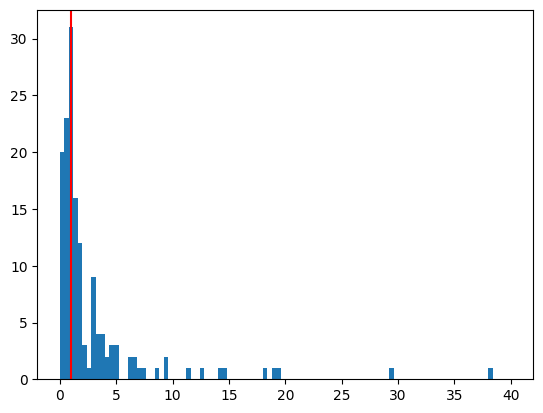

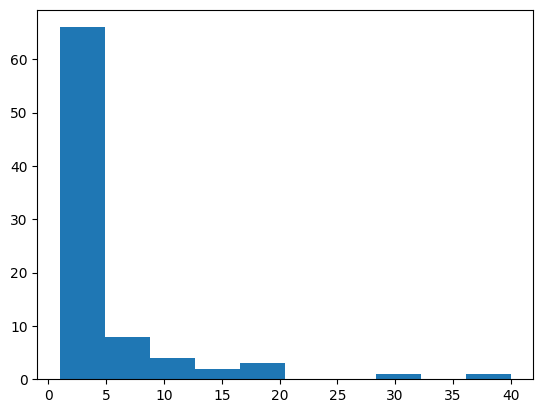

In [12]:
fig, ax = plt.subplots()
ax.hist(available_targets["t_total"], bins=100, range=(0, 40))
ax.axvline(1, color='r')

fig, ax = plt.subplots()
ax.hist(available_targets["t_total"], bins=10, range=(1, 40))

list all targets, sorted by observing time

In [13]:
print("total targets: {}".format(len(available_targets)))
print("targets with > 1 hr: {}".format(np.sum(available_targets["t_total"] >= 1)))
available_targets["target_name", "t_total"].pprint(max_lines=-1)

total targets: 149
targets with > 1 hr: 85
      target_name              t_total      
------------------------ -------------------
                   GNZ11  38.093208333333315
                  GALCEN  29.311380000000003
       SDSSJ1652-NIRSPEC   19.24922722222222
                NGC-4151  18.965560000000004
            SGAS1723-IFU   18.34959111111111
          SPT0346-52-IFU            14.58888
            SGAS1723-SKY  14.001288888888887
                  URANUS            12.40694
          ORIBAR-NIRSPEC  11.595779999999893
SDSS-J083200.20+161500.3   9.320673333333334
            SGAS1226-IFU   9.207208888888887
            HE-0435-1223            8.753335
   SPT0346-52-IFU-OFFSET   7.440329999999999
         XID2028-NIRSPEC  6.8081475000000005
                Z6.1-6.2   6.548791111111111
             BG-Z6.1-6.2   6.548791111111111
          VDESJ0020-3653   6.078703333333333
               2011HM102   6.078703333333333
       SDSSJ0749-NIRSPEC   4.964271666666667
            

total hours of NirspecIFU data

In [14]:
available_targets["t_total"].sum()

437.8358174999999

In principle some targets may have been observed by differenet proposals - check if this is the case (it is likely not as the telescope is so new)

In [15]:
targets = np.unique(with_data["target_name"])

for target_name in targets:
    num_proposals = np.unique(
        with_data[with_data["target_name"] == target_name]["proposal_id"]).size
    #print("{}:  {}".format(target_name, num_proposals))
    if num_proposals>1 :
        print("{}:  {}".format(target_name, num_proposals))
    

so indeed target <--> is one-to-one

make csv of this table to import into excel

In [16]:
available_targets.write("jwst_nirspec_ifu-available.html", format='html', overwrite=True)

check other instruments on jwst? which instruments have data?

In [17]:
all_jwst = obv.query_criteria(obs_collection="JWST")

In [18]:
np.unique(all_jwst["instrument_name"]).pprint(max_lines=-1)

instrument_name
---------------
            FGS
       FGS/FGS1
       FGS/FGS2
           MIRI
     MIRI/CORON
       MIRI/IFU
     MIRI/IMAGE
      MIRI/SLIT
  MIRI/SLITLESS
   MIRI/TARGACQ
         NIRCAM
   NIRCAM/CORON
   NIRCAM/GRISM
   NIRCAM/IMAGE
 NIRCAM/TARGACQ
         NIRISS
     NIRISS/AMI
   NIRISS/IMAGE
    NIRISS/SOSS
    NIRISS/WFSS
        NIRSPEC
    NIRSPEC/IFU
  NIRSPEC/IMAGE
    NIRSPEC/MSA
   NIRSPEC/SLIT


In [19]:
all_jwst_spectra = obv.query_criteria(obs_collection="JWST", 
                                      instrument_name=["NIRSPEC/MSA", "NIRSPEC/IFU"])

In [20]:
all_spectra_with_data = all_jwst_spectra[~all_jwst_spectra["dataURL"].mask]

In [21]:
available_targets_full = table.Table(
    names=["target_name", "t_total", "RA", "Dec", "instrument", "proposal_id", "PI", "description"], 
    dtype=[str, float, float, float, str, str, str, str])
for row in all_spectra_with_data:
    target_name = row["target_name"]
    t_exp = row["t_exptime"]/3600.0
    if target_name not in available_targets_full["target_name"]:
        available_targets_full.add_row(
            [target_name, t_exp, row["s_ra"], row["s_dec"], row["instrument_name"],
             row["proposal_id"], row["proposal_pi"], row["obs_title"]])
    available_targets_full["t_total"][available_targets_full["target_name"] == target_name] += t_exp

In [22]:
available_targets_full.sort("t_total")
available_targets_full.reverse()

In [23]:
print("total hours: {}".format(available_targets_full["t_total"].sum()))
print("total targets: {}".format(len(available_targets_full)))

available_targets_full["target_name", "t_total", "instrument"].pprint(max_lines=-1)


total hours: 83770.12338861168
total targets: 521
          target_name                 t_total         instrument
------------------------------- -------------------- -----------
                  GS-MEDIUM-HST      9648.9814950006 NIRSPEC/MSA
    1181-MERGED-APT-CLEAN-CLEAN    9576.400374166416 NIRSPEC/MSA
              DEEP-HST-V1-CLEAN    8440.402004999982 NIRSPEC/MSA
    21_3_23_mediumjwst_trim_ta5    6161.295838055785 NIRSPEC/MSA
              cosmos_zsel_final    6025.211378333322 NIRSPEC/MSA
                            v16    2904.323696666676 NIRSPEC/MSA
                   MPTCAT092722    2787.288483888904 NIRSPEC/MSA
           BLUEJAY-MASTER-SOUTH   2637.5256199999994 NIRSPEC/MSA
               MUSE-DR2-MXDF-V2   2341.5168450000024 NIRSPEC/MSA
Q2343-22J7-TAJ10-WBS-CONJ28-M25     2097.55818444444 NIRSPEC/MSA
 21_3_23_mediumjwst_trim_ta5_v2   2010.1053033333164 NIRSPEC/MSA
   MERGED-TRIMMED-NIRCAM-CAT-V1   1837.1052574999824 NIRSPEC/MSA
            MSA-FINAL-CAT-MSATA   1659.4

This total hours is 

In [24]:
print("{} years".format(available_targets_full["t_total"].sum()/(365*24)))

9.562799473585809 years


so something here is wrong....

In [25]:
available_targets_full[0]

target_name,t_total,RA,Dec,instrument,proposal_id,PI,description
str31,float64,float64,float64,str11,str4,str29,str150
GS-MEDIUM-HST,9648.9814950006,53.15372125,-27.78036944444443,NIRSPEC/MSA,1180,"Eisenstein, Daniel J.",NIRCam-NIRSpec galaxy assembly survey - GOODS-S - part #1a


In [26]:
all_jwst[all_jwst["intentType"]=="calibration"]["obs_title"]

NIRCam Pre-Coarse Phasing Verification (CAR NIRCam-05)
OTE-26 Routine WFSC/CC Jitter Maintenance
JWST Routine Wavefront Sensing and Control for Cycle 1 - Part 1
Absolute Flux Calibration (G Dwarfs)
OTE-26 Routine WFSC/CC Jitter Maintenance
...
NIRCam Subarray Dark Current and Read-Noise Monitor
Absolute Flux Calibration (White Dwarfs)
OTE-07 Global Alignment 1
OTE-12 Coarse Phasing - 1 (For Coarse MIMF)


In [27]:
GNZ11 = with_data[with_data["target_name"] == "GNZ11"]
GNZ11

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str7,str11,str4,str12,str8,str27,str1,str39,float64,float64,str8,str29,int64,float64,float64,float64,float64,float64,str148,float64,str4,str3,int64,str182,str65,str66,str6,bool,float64,str9,str9
science,JWST,CALJWST,NIRSPEC/IFU,JWST,F170LP;G235M,INFRARED,GNZ11,--,jw04426-o001_t001_nirspec_g235m-f170lp,189.1060420833333,62.24204166666667,cube,"Maiolino, Roberto",3,60087.18656565764,60087.64128767361,37931.10999999999,1660.0,5000.0,An unprecedented spatially resolved analysis of the brightest galaxy at z>10 in GOODS-N,60088.57688648,4426,DD,--,POLYGON 189.104446574 62.241523579 189.104446574 62.24263469 189.107190187 62.24263469 189.107190187 62.241523579,mast:JWST/product/jw04426-o001_t001_nirspec_g235m-f170lp_s3d.jpg,mast:JWST/product/jw04426-o001_t001_nirspec_g235m-f170lp_s3d.fits,PUBLIC,False,nan,139257240,254462456
science,JWST,CALJWST,NIRSPEC/IFU,JWST,F100LP;G140M,INFRARED,GNZ11,--,jw04426-o001_t001_nirspec_g140m-f100lp,189.1060420833333,62.24204166666667,cube,"Maiolino, Roberto",3,60087.64415798507,60087.79055493056,11671.11,700.0,5000.0,An unprecedented spatially resolved analysis of the brightest galaxy at z>10 in GOODS-N,60088.57688648,4426,DD,--,POLYGON 189.104438784 62.241521819 189.104438784 62.24263293 189.107182396 62.24263293 189.107182396 62.241521819,mast:JWST/product/jw04426-o001_t001_nirspec_g140m-f100lp_s3d.jpg,mast:JWST/product/jw04426-o001_t001_nirspec_g140m-f100lp_s3d.fits,PUBLIC,False,nan,139257277,254462505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
science,JWST,CALJWST,NIRSPEC/IFU,JWST,F100LP;G140M,INFRARED,GNZ11,--,jw04426001001_04101_00003_nrs2,189.1060420833333,62.24204166666667,image,"Maiolino, Roberto",2,60087.67370757998,60087.68738466435,1167.111,700.0,5000.0,An unprecedented spatially resolved analysis of the brightest galaxy at z>10 in GOODS-N,60088.54793974,4426,DD,--,POLYGON 189.104727689 62.242567058 189.106634511 62.242527523 189.106574567 62.241667694 189.104668078 62.241707027,mast:JWST/product/jw04426001001_04101_00003_nrs2_rateints.jpg,mast:JWST/product/jw04426001001_04101_00003_nrs2_rateints.fits,PUBLIC,False,nan,139243752,254475304
science,JWST,CALJWST,NIRSPEC/IFU,JWST,F100LP;G140M,INFRARED,GNZ11,--,jw04426001001_04101_00008_nrs2,189.1060420833333,62.24204166666667,image,"Maiolino, Roberto",2,60087.74732825127,60087.76100533565,1167.111,700.0,5000.0,An unprecedented spatially resolved analysis of the brightest galaxy at z>10 in GOODS-N,60088.55570586,4426,DD,--,POLYGON 189.104936169 62.242584304 189.106842992 62.242544767 189.106783042 62.241684938 189.104876552 62.241724274,mast:JWST/product/jw04426001001_04101_00008_nrs2_rateints.jpg,mast:JWST/product/jw04426001001_04101_00008_nrs2_rateints.fits,PUBLIC,False,nan,139243790,254475428
science,JWST,CALJWST,NIRSPEC/IFU,JWST,F170LP;G235M,INFRARED,GNZ11,--,jw04426001001_02101_00008_nrs2,189.1060420833333,62.24204166666667,image,"Maiolino, Roberto",2,60087.50603571551,60087.55027517361,3793.111,1660.0,5000.0,An unprecedented spatially resolved analysis of the brightest galaxy at z>10 in GOODS-N,60088.55951381,4426,DD,--,POLYGON 189.104935628 62.242584544 189.106842451 62.242545005 189.106782497 62.241685176 189.104876007 62.241724514,mast:JWST/product/jw04426001001_02101_00008_nrs2_rateints.jpg,mast:JWST/product/jw04426001001_02101_00008_nrs2_rateints.fits,PUBLIC,False,nan,139243801,254475484


In [28]:
obv.get_product_list(GNZ11[1])

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str9,str4,str5,str38,str64,str1,str70,str9,str28,str9,str1,str7,str6,str4,str52,int64,str9,str6,int64
139257277,JWST,cube,jw04426-o001_t001_nirspec_g140m-f100lp,source/target (L3) : association generator,D,mast:JWST/product/jw04426-o001_20230524t125457_spec3_00001_asn.json,INFO,Minimum Recommended Products,ASN,--,CALJWST,1.10.1,4426,jw04426-o001_20230524t125457_spec3_00001_asn.json,4013,139257277,PUBLIC,3
139257277,JWST,cube,jw04426-o001_t001_nirspec_g140m-f100lp,source/target (L3) : association pool,D,mast:JWST/product/jw04426_20230524t125457_pool.csv,INFO,Minimum Recommended Products,POOL,--,CALJWST,1.10.1,4426,jw04426_20230524t125457_pool.csv,17655,139257277,PUBLIC,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139243647,JWST,image,jw04426001001_04101_00010_nrs1,FGS guide star tracking,S,mast:JWST/product/jw04426001001_gs-track_2023143183812_uncal.fits,AUXILIARY,--,GS-TRACK,--,CALJWST,--,4426,jw04426001001_gs-track_2023143183812_uncal.fits,915840,139257277,PUBLIC,1
139243647,JWST,image,jw04426001001_04101_00010_nrs1,Preview-Full,S,mast:JWST/product/jw04426001001_04101_00010_nrs1_uncal.jpg,PREVIEW,--,--,--,CALJWST,--,4426,jw04426001001_04101_00010_nrs1_uncal.jpg,1585489,139257277,PUBLIC,1
139243647,JWST,image,jw04426001001_04101_00010_nrs1,exposure (L1b): Uncalibrated 4D exposure data,S,mast:JWST/product/jw04426001001_04101_00010_nrs1_uncal.fits,SCIENCE,--,UNCAL,--,CALJWST,--,4426,jw04426001001_04101_00010_nrs1_uncal.fits,209767680,139257277,PUBLIC,1


In [29]:
np.unique(obv.get_product_list(GNZ11[1])["description"])

FGS guide star fine guide
FGS guide star identification
FGS guide star tracking
FGS1 guide star acquisition
FGS2 guide star acquisition
...
exposure/target (L2b/L3): 1D extracted spectrum
exposure/target (L2b/L3): 3D image of spectrum
source/target (L3) : association generator
source/target (L3) : association pool


In [30]:
test = all_spectra_with_data[all_spectra_with_data["target_name"] == "GS-MEDIUM-HST"][0]
test

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str11,str4,str7,str11,str4,str12,str8,str31,str1,str41,float64,float64,str8,str31,int64,float64,float64,float64,float64,float64,str150,float64,str4,str3,int64,str182,str67,str68,str16,bool,float64,str9,str9
science,JWST,CALJWST,NIRSPEC/MSA,JWST,F170LP;G235M,Infrared,GS-MEDIUM-HST,--,jw01180-o135_s09657_nirspec_f170lp-g235m,53.15372125,-27.78036944444443,image,"Eisenstein, Daniel J.",3,59972.18571851482,59972.63680924768,9322.298999999999,1660.0,5000.0,NIRCam-NIRSpec galaxy assembly survey - GOODS-S - part #1a,60338.58098364,1180,GTO,--,POLYGON 53.173231306 -27.818050097 53.173611204 -27.818050097 53.173611204 -27.818714517 53.173231306 -27.818714517,mast:JWST/product/jw01180-o135_s09657_nirspec_f170lp-g235m_cal.jpg,mast:JWST/product/jw01180-o135_s09657_nirspec_f170lp-g235m_s2d.fits,EXCLUSIVE_ACCESS,False,nan,120902629,248184140


In [31]:
obv.get_product_list(test)[-1]

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str9,str4,str8,str40,str71,str1,str68,str9,str28,str8,str1,str7,str5,str4,str50,int64,str9,str16,int64
112312462,JWST,spectrum,jw01180135001_0310j_00003_nrs2,exposure/target (L2b/L3): 1D extracted spectrum,S,mast:JWST/product/jw01180135001_0310j_00003_nrs2_x1d.fits,SCIENCE,--,X1D,--,CALJWST,1.8.2,1180,jw01180135001_0310j_00003_nrs2_x1d.fits,31464000,120902629,EXCLUSIVE_ACCESS,2


In [32]:
obv.get_product_list(test)[-1]["dataURI"]

'mast:JWST/product/jw01180135001_0310j_00003_nrs2_x1d.fits'

In [33]:
obv.download_file(obv.get_product_list(test)[-1]["dataURI"])

('ERROR',
 'HTTPError: 401 Client Error: Unauthorized for url: https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:JWST/product/jw01180135001_0310j_00003_nrs2_x1d.fits',
 'https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:JWST/product/jw01180135001_0310j_00003_nrs2_x1d.fits')

In [34]:
obv.download_file(obv.get_product_list(GNZ11[1])[-1]["dataURI"])

INFO: Found cached file /home/rjanish/physics/optical-ir-axion-decay/jw04426001001_04101_00010_nrs1_uncal.fits with expected size 209767680. [astroquery.query]


('COMPLETE', None, None)

In [35]:
obv.get_metadata("observations")

Column Name,Column Label,Data Type,Units,Description,Examples/Valid Values
str21,str25,str7,str10,str72,str116
intentType,Observation Type,string,,Whether observation is for science or calibration.,"Valid values: science, calibration"
obs_collection,Mission,string,,Collection,"E.g. SWIFT, PS1, HST, IUE"
...,...,...,...,...,...
dataURL,Data URL,string,,Data URL,
proposal_type,Proposal Type,string,,Type of telescope proposal,"Eg. 3PI, GO, GO/DD, HLA, GII, AIS"
sequence_number,Sequence Number,integer,,"Sequence number, e.g. Kepler quarter or TESS sector",


In [36]:
obv.filter_products(obv.get_product_list(GNZ11[0]), productGroupDescription="Minimum Recommended Products")

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str9,str4,str5,str38,str64,str1,str70,str9,str28,str9,str1,str7,str6,str4,str52,int64,str9,str6,int64
139257240,JWST,cube,jw04426-o001_t001_nirspec_g235m-f170lp,source/target (L3) : association generator,D,mast:JWST/product/jw04426-o001_20230524t125457_spec3_00002_asn.json,INFO,Minimum Recommended Products,ASN,--,CALJWST,1.10.1,4426,jw04426-o001_20230524t125457_spec3_00002_asn.json,4013,139257240,PUBLIC,3
139257240,JWST,cube,jw04426-o001_t001_nirspec_g235m-f170lp,source/target (L3) : association pool,D,mast:JWST/product/jw04426_20230524t125457_pool.csv,INFO,Minimum Recommended Products,POOL,--,CALJWST,1.10.1,4426,jw04426_20230524t125457_pool.csv,17655,139257240,PUBLIC,3
139257240,JWST,cube,jw04426-o001_t001_nirspec_g235m-f170lp,exposure/target (L2b/L3): 3D image of spectrum,D,mast:JWST/product/jw04426-o001_t001_nirspec_g235m-f170lp_s3d.fits,SCIENCE,Minimum Recommended Products,S3D,--,CALJWST,1.10.1,4426,jw04426-o001_t001_nirspec_g235m-f170lp_s3d.fits,44988480,139257240,PUBLIC,3
139257240,JWST,cube,jw04426-o001_t001_nirspec_g235m-f170lp,exposure/target (L2b/L3): 1D extracted spectrum,D,mast:JWST/product/jw04426-o001_t001_nirspec_g235m-f170lp_x1d.fits,SCIENCE,Minimum Recommended Products,X1D,--,CALJWST,1.10.1,4426,jw04426-o001_t001_nirspec_g235m-f170lp_x1d.fits,483840,139257240,PUBLIC,3


In [37]:
min_rec = obv.filter_products(obv.get_product_list(GNZ11[0:2]), productGroupDescription="Minimum Recommended Products")

In [38]:
out = obv.download_products(min_rec, download_dir="~/progs/physics")

INFO: 1 of 8 products were duplicates. Only downloading 7 unique product(s). [astroquery.mast.observations]


In [39]:
out

Local Path,Status,Message,URL
str122,str8,object,object
~/progs/physics/mastDownload/JWST/jw04426-o001_t001_nirspec_g140m-f100lp/jw04426-o001_20230524t125457_spec3_00001_asn.json,COMPLETE,None,None
~/progs/physics/mastDownload/JWST/jw04426-o001_t001_nirspec_g235m-f170lp/jw04426-o001_20230524t125457_spec3_00002_asn.json,COMPLETE,None,None
~/progs/physics/mastDownload/JWST/jw04426-o001_t001_nirspec_g140m-f100lp/jw04426-o001_t001_nirspec_g140m-f100lp_s3d.fits,COMPLETE,None,None
~/progs/physics/mastDownload/JWST/jw04426-o001_t001_nirspec_g140m-f100lp/jw04426-o001_t001_nirspec_g140m-f100lp_x1d.fits,COMPLETE,None,None
~/progs/physics/mastDownload/JWST/jw04426-o001_t001_nirspec_g235m-f170lp/jw04426-o001_t001_nirspec_g235m-f170lp_s3d.fits,COMPLETE,None,None
~/progs/physics/mastDownload/JWST/jw04426-o001_t001_nirspec_g235m-f170lp/jw04426-o001_t001_nirspec_g235m-f170lp_x1d.fits,COMPLETE,None,None
~/progs/physics/mastDownload/JWST/jw04426-o001_t001_nirspec_g140m-f100lp/jw04426_20230524t125457_pool.csv,COMPLETE,None,None


In [40]:
np.unique(with_data["proposal_id"])

1022
1118
1120
1125
1128
...
2729
2732
2747
4426
